In [29]:
from sklearn.neighbors import NearestNeighbors
from numpy.linalg import eig
import numpy as np
import cv2
import os
import sys
import pickle


#back_camera_path = os.path.abspath('video/2023-04-29_16-40-01-back.mp4')
#left_camera_path = os.path.abspath('video/2023-04-29_16-40-01-left_repeater.mp4')
back_camera_path = os.path.abspath('back_video_masked.avi')
left_camera_path = os.path.abspath('left_video_masked.avi')


***Part 2***

1- Get the camera extrinsics (i.e Camera Calibration)

2- 3D Reconstruction or something else

***Back Camera Intrinsics***

Intrinsic matrix K(1,1) K(2,2) K(1,3) K(2,3) 
519.4039      518.0534      656.7379      451.5029 


Radial distortion coef k1 k2 k3 
-0.26584    0.067382  -0.0073529 


***Left Camera Intrinsics***

Intrinsic matrix K(1,1) K(2,2) K(1,3) K(2,3) 
1007.4921      1001.9244      622.32689      481.29046 

Radial distortion coef k1 k2 k3 
-0.37839     0.18775   -0.051045 


In [21]:
def matching_features_SCIKITLEARN(sift_points):
    """Feature matching using nearest neighbours, for pairs of consecutive frames"""
    
    matches=[]
    Threshold=0.75
        
    for s in range(len(sift_points)-1):
        frame1_descriptors = sift_points[s][0][2:,:] #descriptor values of every feature point for video frame s (current shape: 128x5000)
        frame1_descriptors = np.transpose(frame1_descriptors) # transpose -> current shape: 5000x128 - > 5000 points/queries each with 128 features/columns
        #fit data of features from frame 1 to NearestNeighbour. When we ask for matches from this method, it should give us the 2 closest points to the point given
        nbrs = NearestNeighbors(n_neighbors=2, algorithm='auto').fit(frame1_descriptors) 

        #predict matches for the other frame:
        
        frame_drescriptors = np.transpose(sift_points[s+1][0][2:,:]) #the same as done some lines above but for frame s+1
        # Find the 2 nearest neighbors
        distances, indices = nbrs.kneighbors(frame_drescriptors) 
        # indices is a 5000x2 shape matrix -> for each of the 5000 given feature points of frame_drescriptors it gives the 2 closest features from video frame 1
        # distances is a measure of distance between the feature points of frame_drescriptors and each of the two givenneighbours from the indices matrix - it has the same size as indices
        
        features_matches=np.empty([4,0])
        features_not_mateched=[]
        for i in range(len(distances)): 
            if distances[i,0]< Threshold*distances[i,1]:
                #match is good for first neighbour found
                features_matches= np.hstack((  features_matches   , np.array([[int(i)],[int(indices[i,0])], [distances[i,0]],[distances[i,1]]])  ))
            else:                
                #point is not good
                features_not_mateched.append(i) #features from this frame that were not matched
        
        features_matches = features_matches[:, features_matches[1, :].argsort()] # this sorts the check_for_duplicates matrix in accordance to the values of it's second line
        features_matches_deletedColumns= features_matches.copy()

        for i in reversed (range (1, features_matches.shape[1])): #loop that starts in the last feature - because it deletes elements with their indexes from list check_for_duplicates_deletedColumns
            # this has to be done starting from the end to not change the index of columns

            # duplicates are adjacent because of sort
            if features_matches[1,i-1] == features_matches[1,i]:
                # if the value of the indice i and i-1 are equal, then there is one feature matched to 2 features of the new frame - we need to delete one of the matches
                if features_matches[2,i-1] <= features_matches[2,i]: #check distance of i and i-1. And remove the one with the most distance
                    features_matches_deletedColumns= np.delete(features_matches_deletedColumns, i-1, 1) #remove duplicate feature matching (deletes one column - np dimension 1)
                    features_not_mateched.append(features_matches[0,i-1]) #append number of feature that was deleted to features not matched
                else:
                    features_matches_deletedColumns= np.delete(features_matches_deletedColumns, i, 1) 
                    features_not_mateched.append(features_matches[0,i]) 
        
        matched_inThis_frame = features_matches_deletedColumns[:, features_matches_deletedColumns[0, :].argsort()] #to be in order in acoordance to index of frame s

        matches.append( (matched_inThis_frame[0:2,:]))

    return matches

In [22]:
def count_frames(video_path):
    """Displays the video and counts the number of frames"""
    capture = cv2.VideoCapture(os.path.abspath(video_path))
    total_frames = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
    print("Total frames of the video: ", total_frames)

def extract_features(video_path, number_points):
    """Extracts the features from the video and stores them in a list"""
    capture = cv2.VideoCapture(os.path.abspath(video_path))
    sift_points = [] #nome a definir no config
    nr_points = number_points
    sift = cv2.SIFT_create(nr_points) #number of sift points
    k = 0
    count_frames(video_path)
    while k <= 0:
        capture.set(cv2.CAP_PROP_POS_FRAMES, k)
        success, frame = capture.read() #read the video
        if success:
            frame_points = []
            gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY) #convert image to gray
            key_points, descriptors = sift.detectAndCompute(gray,None) 
            
            frame_points = ([key_points[0].pt[0],key_points[0].pt[1]]+descriptors[0].tolist())
            for i in range(1,len(key_points)):
                 temp_column = ([key_points[i].pt[0],key_points[i].pt[1]]+descriptors[i].tolist())
                 frame_points = np.column_stack((frame_points,temp_column))  
        sift_points.append(frame_points) #append everything into a list 
        k += 100
    print("(Nº features, Nº descriptors per feature): ", descriptors.shape)
    print("Nº of frames extracted: ", len(sift_points))
    return sift_points, nr_points

In [23]:
def back_left_matches(matches, sift_back,sift_left):
    Back_matches = []
    left_matches = []

    for i in range(len(matches[0][0])):
        back = []
        left = []
        b =int(matches[0][0][i])
        l = int(matches[0][1][i])
        back.append(sift_back[0][0][b])
        back.append(sift_back[0][1][b])

        left.append(sift_left[0][0][l])
        left.append(sift_left[0][1][l])

        Back_matches.append(back)
        left_matches.append(left)

    return Back_matches, left_matches

In [24]:
def undistort_points(back_points_distorted,left_points_distorted):
    Back_CameraMatrix = np.array([[519.4039, 0, 656.7379],[ 0, 518.0534, 451.5029],[ 0, 0, 1] ])
    Back_RadialDistortion =np.array( [-0.26584,0.067382,0,0,-0.0073529,0,0,0,0,0,0,0,0,0 ])

    Left_CameraMatrix = np.array([[1007.4921, 0, 622.32689],[ 0, 1001.9244, 481.29046],[ 0, 0, 1] ])
    Left_RadialDistortion = np.array([-0.37839, 0.18775,0,0,-0.051045 ,0,0,0,0,0,0,0,0,0 ])

    back_points_undistorted = cv2.undistortPoints(np.array(back_points_distorted),Back_CameraMatrix,Back_RadialDistortion)
    left_points_undistorted = cv2.undistortPoints(np.array(left_points_distorted),Left_CameraMatrix,Left_RadialDistortion)

    return back_points_undistorted, left_points_undistorted


In [30]:
both_cameras_sift = []
sift_back, _ = extract_features(back_camera_path, 2000)  # Extracting only one frame from it 
sift_left, _ = extract_features(left_camera_path, 2000)
both_cameras_sift.append(sift_back)
both_cameras_sift.append(sift_left)
matches = matching_features_SCIKITLEARN(both_cameras_sift)

#Select the points from the back camera and left camera that match
back_points_distorted, left_points_distorted = back_left_matches(matches, sift_back,sift_left) 

#Undistort the previous points, and obtain their coordinates
back_points, left_points = undistort_points(back_points_distorted,left_points_distorted)

#Obtain the Essential Matrix from the two Cameras
E, mask = cv2.findEssentialMat(back_points, left_points, np.eye(3,3), cv2.RANSAC) 

#Decompose the Essential Matrix to obtain the most likely Rotation and Translation
points, R, t, _ = cv2.recoverPose(E, back_points, left_points)

#Another Option:
# s = cv2.decomposeEssentialMat(E)    # s is a struct

Total frames of the video:  31
(Nº features, Nº descriptors per feature):  (2000, 128)
Nº of frames extracted:  1
Total frames of the video:  0


UnboundLocalError: local variable 'frame_points' referenced before assignment

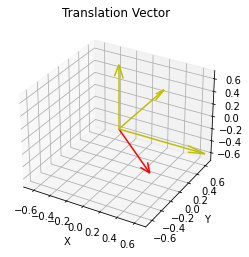

In [209]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x_axis = [1,0,0]
y_axis = [0,1,0]
z_axis = [0,0,1]
x_axis=np.reshape(x_axis,(3,1))
y_axis=np.reshape(y_axis,(3,1))
z_axis=np.reshape(z_axis,(3,1))
#VECTOR 1
ax.quiver(0, 0, 0, t[0], t[1], t[2], color='r', arrow_length_ratio=0.2)
#VECTOR 2
ax.quiver(0, 0, 0, x_axis[0], x_axis[1], x_axis[2], color='y', arrow_length_ratio=0.2)
ax.quiver(0, 0, 0, y_axis[0],y_axis[1], y_axis[2], color='y', arrow_length_ratio=0.2)
ax.quiver(0, 0, 0, z_axis[0],z_axis[1], z_axis[2], color='y', arrow_length_ratio=0.2)
#ax.quiver(0, 0, 0, v2[0], v2[1], v2[2], color='b', arrow_length_ratio=0.1)

ax.set_xlim([-0.7, 0.7])
ax.set_ylim([-0.7, 0.7])
ax.set_zlim([-0.7, 0.7])

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('Translation Vector')

plt.show()

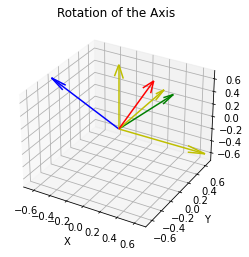

In [207]:
x_axis = [1,0,0]
y_axis = [0,1,0]
z_axis = [0,0,1]
x_axis=np.reshape(x_axis,(3,1))
y_axis=np.reshape(y_axis,(3,1))
z_axis=np.reshape(z_axis,(3,1))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = R.dot(x_axis)
y = R.dot(y_axis)
z = R.dot(z_axis)


#VECTOR 1
ax.quiver(0, 0, 0, x[0], x[1], x[2], color='r', arrow_length_ratio=0.2)
ax.quiver(0, 0, 0, x_axis[0], x_axis[1], x_axis[2], color='y', arrow_length_ratio=0.2)
#VECTOR 2
ax.quiver(0, 0, 0, y[0], y[1], y[2], color='g', arrow_length_ratio=0.2)
ax.quiver(0, 0, 0, y_axis[0],y_axis[1], y_axis[2], color='y', arrow_length_ratio=0.2)
#VECTOR 3
ax.quiver(0, 0, 0, z[0], z[1], z[2], color='b', arrow_length_ratio=0.2)
ax.quiver(0, 0, 0, z_axis[0],z_axis[1], z_axis[2], color='y', arrow_length_ratio=0.2)
#ax.quiver(0, 0, 0, v2[0], v2[1], v2[2], color='b', arrow_length_ratio=0.1)

ax.set_xlim([-0.7, 0.7])
ax.set_ylim([-0.7, 0.7])
ax.set_zlim([-0.7, 0.7])

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('Rotation of the Axis')

plt.show()